In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

from scipy.stats import loguniform

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
# import sklearn 
# sklearn.metrics.get_scorer_names()

In [5]:
dataset = pd.read_csv("train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("features.csv",sep=',', header=0,names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')
dataset.head()

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


# Data manipulation

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

dataset['Type'] = enc.fit_transform(dataset['Type'])
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
# dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset = dataset.drop(columns=["Date"])
# dataset = dataset.sample(5000)
dataset.head()

,Store,Dept,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month
0,1,1,24924.50,False,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2
1,1,1,46039.49,True,0,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2
2,1,1,41595.55,False,0,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2
3,1,1,19403.54,False,0,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2
4,1,1,21827.90,False,0,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,3


In [5]:
# dataset.astype("category").info()

In [7]:
x = dataset.drop(columns=['weeklySales'])
y = dataset["weeklySales"]

from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1, 1))
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y_scaled,test_size =.1,random_state=1)

# Algorithms

In [ ]:
# knn_reg = KNeighborsRegressor()
# param_grid_knn = [{'n_neighbors': [50], 'weights':['uniform'], 'leaf_size':[10], 'n_jobs':[-1], 'p':[1], 'algorithm':['auto']}]
# grid_search_knn = GridSearchCV(knn_reg, param_grid_knn, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_knn = grid_search_knn.fit(x_train,y_train)
# print('knn best params',results_knn.best_params_)
# model_knn = KNeighborsRegressor(**results_knn.best_params_)
model_knn = KNeighborsRegressor(n_neighbors= 50, weights='uniform', leaf_size=10, n_jobs=-1, p=1, algorithm='auto')
model_knn.fit(x_train,y_train)
predicted_knn = model_knn.predict(x_test)
results_knn = mean_absolute_percentage_error(y_test, predicted_knn)
print('knn mape', results_knn)

best_results = results_knn
best_model = model_knn

# extra_trees_reg = ExtraTreesRegressor()
# param_grid_extra_trees = [{'n_estimators': [1000], 'max_features': [0.5], 'n_jobs':[-1], 'warm_start':[True],
#                            'criterion':['squared_error'],'max_depth':[32],'min_samples_split':[12],'min_samples_leaf':[4],
#                            'max_features':[None],'max_leaf_nodes':[None],'bootstrap':[False],'ccp_alpha':[0.2]}]
# grid_search_extra_trees = GridSearchCV(extra_trees_reg, param_grid_extra_trees, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_extra_trees = grid_search_extra_trees.fit(x_train,y_train)
# print('extra trees best params',results_extra_trees.best_params_)
# model_extra_trees = ExtraTreesRegressor(**results_extra_trees.best_params_)
model_extra_trees = ExtraTreesRegressor(n_estimators=1000, max_features=0.5, n_jobs=-1, warm_start=True,
                           criterion='squared_error',max_depth=32,min_samples_split=12,min_samples_leaf=4,ccp_alpha=0.2)
model_extra_trees.fit(x_train,y_train)
predicted_extra_trees = model_extra_trees.predict(x_test)
results_extra_trees = mean_absolute_percentage_error(y_test, predicted_extra_trees)
print('extra trees mape',results_extra_trees)

if results_extra_trees<best_results:
  best_results = results_extra_trees
  best_model = model_extra_trees

# rf_reg = RandomForestRegressor()
# param_grid_rf = [{'n_estimators': [1000], 'max_features': [0.5], 'n_jobs':[-1], 'warm_start':[True],
#                    'criterion':['squared_error'],'max_depth':[32],'min_samples_split':[12],'min_samples_leaf':[4],
#                    'max_features':[None],'max_leaf_nodes':[None],'bootstrap':[False],'ccp_alpha':[0.2]}]
# grid_search_rf = GridSearchCV(rf_reg, param_grid_rf, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_rf = grid_search_rf.fit(x_train,y_train)
# print('rf best params',results_rf.best_params_)
# model_rf = RandomForestRegressor(**results_rf.best_params_)
model_rf = RandomForestRegressor(n_estimators=1000, max_features=0.5, n_jobs=-1, warm_start=True,
                                 criterion='squared_error',max_depth=32,min_samples_split=12,min_samples_leaf=4,ccp_alpha=0.2)
model_rf.fit(x_train,y_train)
predicted_rf = model_rf.predict(x_test)
results_rf = mean_absolute_percentage_error(y_test, predicted_rf)
print('random forests mape',results_rf)

if results_rf<best_results:
  best_results = results_rf
  best_model = model_rf

knn mape 2.956703331842334


<ipython-input-7-9c0af96530c6>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_extra_trees.fit(x_train,y_train)


extra trees mape 1.000635442664897


<ipython-input-7-9c0af96530c6>:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(x_train,y_train)


extra trees mape 1.00044028544322


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# svm_reg = SVR()
# param_grid_svm = [{'kernel': ['rbf'], 'gamma': ['scale'], 'max_iter':[-1],
#                    'shrinking':[True], 'C':0.14315665733051405loguniform.rvs(1e-5, 1, size=10)}]
# grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_svm = grid_search_svm.fit(x_train,y_train)
# print('svm best params',results_svm.best_params_)
# model_svm = SVR(**results_svm.best_params_)
model_svm = SVR(kernel='rbf', gamma='scale', max_iter=10000, shrinking=True, C=0.14315665733051405)
model_svm.fit(x_train,y_train)
predicted_svm = model_svm.predict(x_test)
results_svm = mean_absolute_percentage_error(y_test, predicted_svm)
print('svm mape',results_svm)

if results_svm<best_results:
  best_results = results_svm
  best_model = model_svm

# xgb_reg = xgb.XGBRegressor()
# param_grid_xgb = [{
#                'n_estimators':[50], 'max_depth':[16], 'max_leaves': [4], 'grow_policy': ['depthwise'],
#                'booster': ['gbtree'], 'n_jobs': [-1]
#                }]
# grid_search_xgb = GridSearchCV(xgb_reg, param_grid_xgb, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_xgb = grid_search_xgb.fit(x_train,y_train)
# print('xgb best params',results_xgb.best_params_)
# model_xgb = xgb.XGBRegressor(**results_xgb.best_params_)
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=16, max_leaves=4, grow_policy='depthwise', booster='gbtree', n_jobs=-1)
model_xgb.fit(x_train,y_train)
predicted_xgb = model_xgb.predict(x_test)
results_xgb = mean_absolute_percentage_error(y_test, predicted_xgb)
print('xgb mape',results_xgb)

if results_xgb<best_results:
  best_results = results_xgb
  best_model = model_xgb

# lgb_reg = lgb.LGBMRegressor()
# param_grid_lgb = [{
#                'n_estimators':[100], 'boosting_type': ['dart'], 'min_split_gain':[0],'min_child_samples':[40],'colsample_bytree': [1],
#                'max_depth':[-1], 'n_jobs':[-1], 'importance_type':['split'], 'reg_alpha': [1e-05], 'reg_lambda': [0.01],
#                }]
# grid_search_lgb = GridSearchCV(lgb_reg, param_grid_lgb, cv=5, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_lgb = grid_search_lgb.fit(x_train,y_train)
# print('lgb best params',results_lgb.best_params_)
# model_lgb = lgb.LGBMRegressor(**results_lgb.best_params_)
model_lgb = lgb.LGBMRegressor(n_estimators=1000, boosting_type= 'dart', min_split_gain=0,min_child_samples=40,colsample_bytree= 1,
               max_depth=-1, n_jobs=-1, importance_type='split', reg_alpha= 1e-05, reg_lambda= 0.01)
model_lgb.fit(x_train,y_train)
predicted_lgb = model_lgb.predict(x_test)
results_lgb = mean_absolute_percentage_error(y_test, predicted_lgb)
print('lgb mape',results_lgb)

if results_lgb<best_results:
  best_results = results_lgb
  best_model = model_lgb

# cat_reg = cat.CatBoostRegressor(task_type="GPU",loss_function='MAPE')
# param_grid_cat = [{
#                'n_estimators':[1000],'min_child_samples':[40],'colsample_bylevel': [1],
#                'depth': [16], 'verbose': [True], 'l2_leaf_reg': [3],'grow_policy':['Lossguide'],'max_leaves': [16384],
#                 'score_function':['L2'],
#                }]
# # grid_search_cat = GridSearchCV(cat_reg, param_grid_cat, cv=2, verbose=1, scoring='neg_mean_absolute_percentage_error')
# # results_cat = grid_search_cat.fit(x_train,y_train)
# # print('cat best params',results_cat.best_params_)
# # model_cat = cat.CatBoostRegressor(**results_cat.best_params_)
model_cat = cat.CatBoostRegressor(loss_function='MAPE', n_estimators=1000,min_child_samples=40,colsample_bylevel= 1,
               depth= 32, verbose= True, l2_leaf_reg= 3,grow_policy='Lossguide',max_leaves= 16384, score_function='L2')
model_cat.fit(x_train,y_train)
predicted_cat = model_cat.predict(x_test)
results_cat = mean_absolute_percentage_error(y_test, predicted_cat)
print('cat mape',results_cat)

if results_cat<best_results:
  best_results = results_cat
  best_model = model_cat

# x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size =.5,random_state=1)
# x_train = np.asarray(x_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
# x_test = np.asarray(x_train).astype(np.float32)
# y_test = np.asarray(y_train).astype(np.float32)
# x_val = np.asarray(x_val).astype(np.float32)
# y_val = np.asarray(y_val).astype(np.float32)

# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
# from keras import regularizers

# model = Sequential()
# model.add(Dense(1,input_shape=(15,),kernel_initializer='he_uniform',
#                 activity_regularizer=regularizers.L2(1e-3), kernel_regularizer=regularizers.L2(l2=1e-3), bias_regularizer=regularizers.L2(1e-3),activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(2,kernel_initializer='he_uniform',
#                 activity_regularizer=regularizers.L2(1e-3), kernel_regularizer=regularizers.L2(l2=1e-3), bias_regularizer=regularizers.L2(1e-3),activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(1, activation="relu"))

# my_callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, restore_best_weights = True),
#                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-8)]

# model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# history=model.fit(x_train,y_train,
#                   validation_data=(x_val,y_val),
#                   batch_size=8, 
#                   epochs=1000,
#                   callbacks=my_callback)

# nn_reg = MLPRegressor(verbose=1)
# param_grid_nn = [{'hidden_layer_sizes': [(300,300,300,300)],'activation': ['relu'], 'solver':['adam'], 'batch_size':[8],'warm_start':[True]}]
# grid_search_nn = GridSearchCV(nn_reg, param_grid_nn, cv=2, verbose=1, scoring='neg_mean_absolute_percentage_error')
# results_nn = grid_search_nn.fit(x_train,y_train)
# print('mlp best params',results_nn.best_params_)
# model_nn = MLPRegressor(**results_nn.best_params_)
# model_nn = MLPRegressor(max_iter=1000,learning_rate= 'adaptive',early_stopping=True,n_iter_no_change=15, verbose=True,
#                         hidden_layer_sizes=(300,300,300,300),activation='relu', solver='adam', batch_size=8,warm_start=True)
# model_nn.fit(x_train,y_train)
# predicted = model_nn.predict(x_test)
# print('mlp mape',mean_absolute_percentage_error(y_test, predicted))

# ValueError: Invalid parameter 'optimizer' for estimator MLPRegressor(hidden_layer_sizes=(10,), verbose=0). 
# Valid parameters are: ['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 
# 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 
# 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start']

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


svm mape 6.542662400111446
xgb mape 0.6984821881292185


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lgb mape 1.23048302452872
0:	learn: 0.4171928	total: 2.58s	remaining: 42m 59s
1:	learn: 0.4057426	total: 6.38s	remaining: 53m 2s
2:	learn: 0.3946576	total: 8.95s	remaining: 49m 35s
3:	learn: 0.3838700	total: 11.6s	remaining: 47m 58s
4:	learn: 0.3734249	total: 14.1s	remaining: 46m 50s
5:	learn: 0.3632362	total: 17.9s	remaining: 49m 18s
6:	learn: 0.3534108	total: 20.4s	remaining: 48m 18s
7:	learn: 0.3438473	total: 23s	remaining: 47m 27s
8:	learn: 0.3345807	total: 25.6s	remaining: 46m 56s
9:	learn: 0.3255928	total: 28.8s	remaining: 47m 28s
10:	learn: 0.3168379	total: 31.7s	remaining: 47m 33s
11:	learn: 0.3083743	total: 34.3s	remaining: 47m 6s
12:	learn: 0.3001155	total: 36.8s	remaining: 46m 34s
13:	learn: 0.2921273	total: 39.3s	remaining: 46m 11s
14:	learn: 0.2843048	total: 43.1s	remaining: 47m 8s
15:	learn: 0.2767469	total: 45.6s	remaining: 46m 41s
16:	learn: 0.2694151	total: 48.1s	remaining: 46m 20s
17:	learn: 0.2623549	total: 50.7s	remaining: 46m 3s
18:	learn: 0.2554378	total: 54.4s	re

Text(0.5, 0, 'CatBoost Feature Importance')

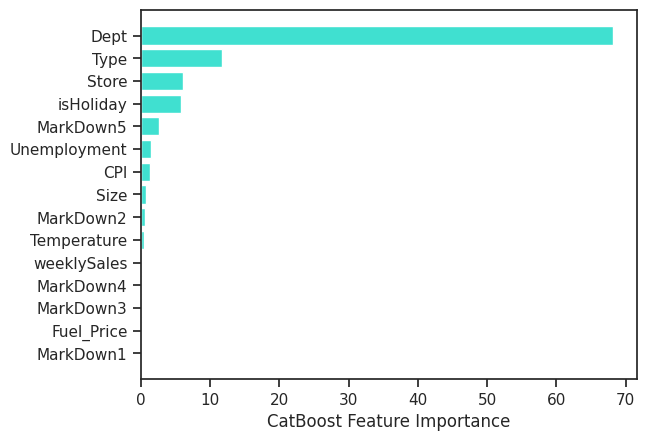

In [22]:
sorted_feature_importance = model_cat.feature_importances_.argsort()
plt.barh(dataset.columns[sorted_feature_importance], 
        model_cat.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [19]:
sorted_feature_importance

array([ 8,  7, 10, 11,  2,  6,  9,  5, 13, 14, 12,  3,  0,  4,  1])

# Test part

In [11]:
dataset_test = pd.read_csv("test.csv", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
features = pd.read_csv("features.csv",sep=',', header=0, names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset_test = dataset_test.merge(stores, how='left').merge(features, how='left')

In [12]:
enc_test = LabelEncoder()
dataset_test['Type'] = enc_test.fit_transform(dataset_test['Type'])
dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset_test = dataset_test.fillna(0)
column_date = dataset_test['Date']
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test = dataset_test.drop(columns=["Date"])
data_test = scaler_x.transform(dataset_test)
data_test[0]

array([-1.65819926, -1.41874236, -0.27510614, -0.8853067 ,  0.23920895,
       -0.25856907,  0.05446611,  0.69003698,  0.83935455, -0.07547074,
        0.65650304,  0.25540484,  1.33457255, -0.74453566,  1.40308062])

In [13]:
predicted_test = scaler_y.inverse_transform(best_model.predict(data_test).reshape(-1, 1))

In [14]:
dataset_test['weeklySales'] = predicted_test
dataset_test['Date'] = column_date
dataset_test['id'] = dataset_test['Store'].astype(str) + '_' +  dataset_test['Dept'].astype(str) + '_' +  dataset_test['Date'].astype(str)
dataset_test = dataset_test[['id', 'weeklySales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [15]:
dataset_test.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,20259.776038
1,1_1_2012-11-09,18558.086553
2,1_1_2012-11-16,18458.168083
3,1_1_2012-11-23,20145.021018
4,1_1_2012-11-30,25884.237296


In [ ]:
# dataset_test.to_csv('output.csv', index=False)